# O's and X's

Run the source code:

In [2]:
%run "code\ox.py"

## Example 6.1

Demonstration of the perfect player. The function `suggest_move(pq=,player=)` takes a board `pq` and a `player` in $\left\{0,1\right\}$ and returns an integer from 0 to 8 indicating the position to be played.

Two perfect players will always produce a draw.

In [3]:
scores, illegals = play_match(suggest_move, suggest_move, bestof=1000)
print(f'Draws: {scores[0]}, \nWins: {scores[1]}, \nLosses: {scores[2]}')

Draws: 1000, 
Wins: 0, 
Losses: 0


Here is an example of a board that ends in a draw. Ignoring rotations and reflections, there are only two unique games that occur between two perfect players; one with a horizontal/vertical symmetry and one with a diagonal symmetry.

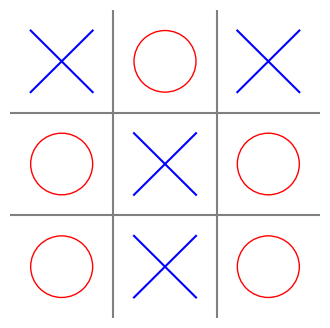

In [4]:
pq, winner, illegal = play_game(suggest_move, suggest_move)
show_board(pq=pq)

Versus a player that selects moves randomly from the available positions, we can see that the perfect player should win almost 100% of the time.

In [5]:
scores, illegals = play_match(suggest_move, random_move, bestof=1000)
print(f'Draws: {scores[0]}, \nWins: {scores[1]}, \nLosses: {scores[2]}')

Draws: 19, 
Wins: 981, 
Losses: 0


## Example 6.2

The example below trains a model with 2 dense layers of size `p` and `q`. The training parameters `r`, `epochs`, and `batch_size` can be modified. Training takes approximately 1 minute per 500 epochs. There is an early stopping criteria with a patience of 20 epochs.

To assess whether the learning rate and number of epochs is set appropriately for the size of the network, a plot of the loss over time is shown. If the loss still appears to be decreasing when the training reaches the last epoch, it may be that we need to increase the number of epochs or increase the learning rate. If the loss over time becomes very jagged with lots of increases and decreases in later epochs, this could suggest that the learning rate needs to be reduced or that the batch size needs to be increased, as the model is struggling to find steps in the given step direction that reduce the loss.

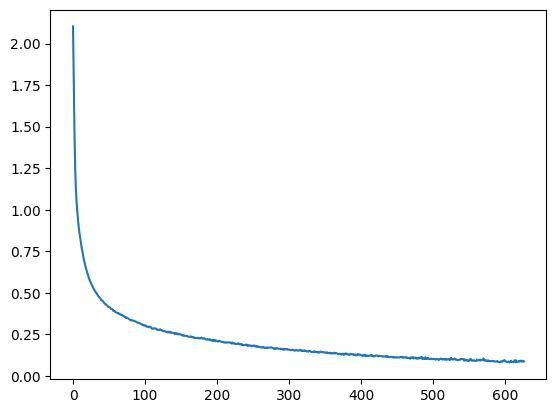

In [6]:
r = 0.002
epochs = 1000
batch_size = 64

M = make_simple_model(p=20, q=20, r=r)
hist = train_model_suggestions(M=M, epochs=epochs, batch_size=batch_size)
plt.plot(hist.history['loss'])
plt.show()

We can now check the performance of the model by testing it in multiple games against the perfect player. The number of matches can be adjusted to better assess performance, although the code is slower than expected and takes around 20 seconds per 100 games. As well as draws, wins, and losses, we monitor the number of losses due to playing illegal moves.

In [7]:
no_games = 100

def test_model_move(pq, player=0, argmax=False):
    return model_move(M=M, pq=pq, player=0, argmax=False)

scores, illegals = play_match(test_model_move, suggest_move, bestof=no_games)
print(f'Draws: {scores[0]}, \nWins: {scores[1]}, \nLosses: {scores[2]}, \nLosses due to illegal moves: {illegals[0]}')

Draws: 65, 
Wins: 0, 
Losses: 35, 
Losses due to illegal moves: 32


We can also use a function to switch the activation on the output layer to argmax rather than softmax, giving us the best possible performance for the chosen network architecture and training.

In [8]:
def test_model_move_argmax(pq, player=0, argmax=True):
    return model_move(M=M, pq=pq, player=0, argmax=True)

scores, illegals = play_match(test_model_move_argmax, suggest_move, bestof=no_games)
print(f'Draws: {scores[0]}, \nWins: {scores[1]}, \nLosses: {scores[2]}, \nLosses due to illegal moves: {illegals[0]}')

Draws: 100, 
Wins: 0, 
Losses: 0, 
Losses due to illegal moves: 0


Finally we can test the argmax model against a random player to see if it also wins almost 100% of the time.

In [9]:
scores, illegals = play_match(test_model_move_argmax, random_move, bestof=no_games)
print(f'Draws: {scores[0]}, \nWins: {scores[1]}, \nLosses: {scores[2]}, \nLosses due to illegal moves: {illegals[0]}')

Draws: 4, 
Wins: 96, 
Losses: 0, 
Losses due to illegal moves: 0


## Example 6.3

With suitable training parameters established, we now repeat the trainig process for models of various sizes, with `p=q` for values ranging from 10 to 20. The range of sizes can be modified by changing `min_size` and `max_size` to experiment over any other ranges of interest.

In [12]:
min_size = 10
max_size = 20

models = []
hists = []
for size in range(min_size, max_size+1):
    M = make_simple_model(p=size, q=size, r=0.002)
    hist = train_model_suggestions(M=M, epochs=1000, batch_size=64)
    models.append(M)
    hists.append(hist)

In [13]:
results_data = test_models(models=models)

The code below plots the results of the test. In particular, we show the draws versus the perfect player for the softmax and argmax models, and the wins versus the random player for the argmax model. In general the larger models perform better but anomalies are often present, which could be caused by randomness in the initial weights as only one model is trained at each size.

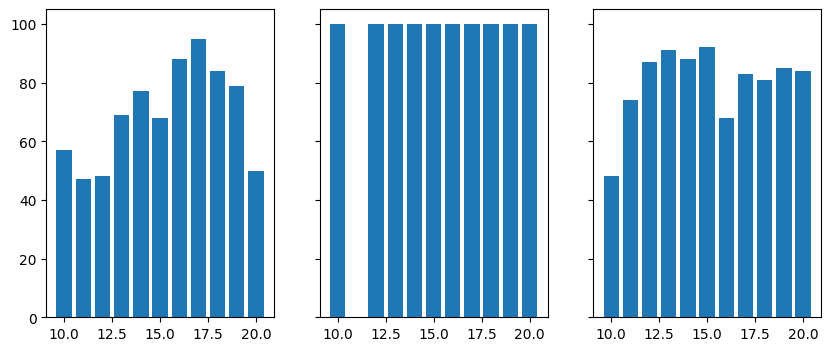

In [14]:
df = pd.DataFrame(list(zip(range(min_size,max_size+1), results_data)), columns=['size','results'])
df['draws_softmax'] = [r[0][0] for r in df['results']]
df['draws_argmax'] = [r[1][0] for r in df['results']]
df['wins_rand'] = [r[2][1] for r in df['results']]

fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(10, 4))

ax[0].bar(df['size'], df['draws_softmax'])
ax[1].bar(df['size'], df['draws_argmax'])
ax[2].bar(df['size'], df['wins_rand'])
plt.show()


We also check the losses due to illegal moves in each game.

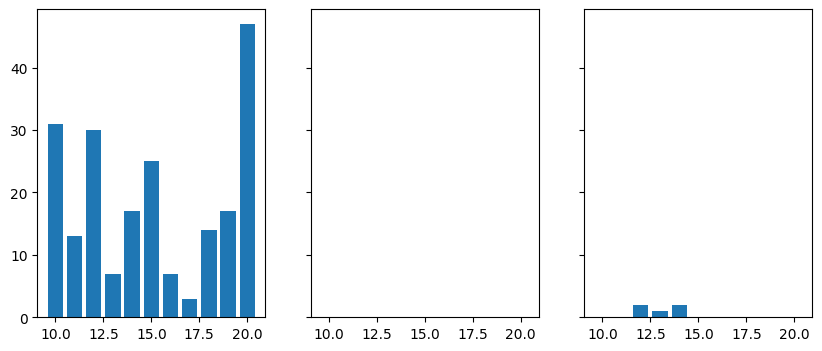

In [15]:
df['illegals_softmax'] = [r[0][3] for r in df['results']]
df['illegals_argmax'] = [r[1][3] for r in df['results']]
df['illegals_rand'] = [r[2][3] for r in df['results']]

fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(10, 4))

ax[0].bar(df['size'], df['illegals_softmax'])
ax[1].bar(df['size'], df['illegals_argmax'])
ax[2].bar(df['size'], df['illegals_rand'])
plt.show()

## Example 6.4

We now repeat the experiment above using models with residual connections. We will test the models with a fixed residual penalty which can be adjusted with the `fix_pen` value, applied to connection weights that cannot be trained. First we verify that the parameters for training are still appropriate.

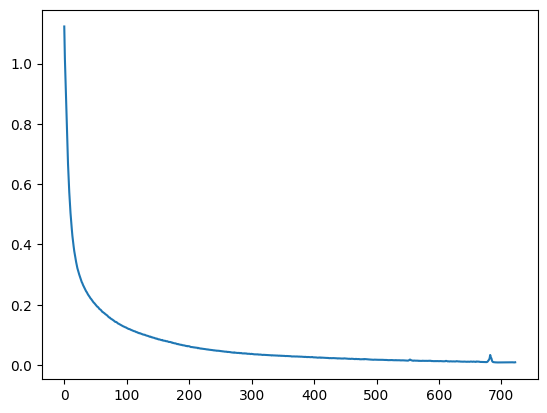

In [16]:
r = 0.002
epochs = 1000
batch_size = 64

M = make_res_model(p=20, q=20, r=r, residual_train=False, fix_pen=20)
hist = train_model_suggestions(M=M, epochs=epochs, batch_size=batch_size)
plt.plot(hist.history['loss'])
plt.show()

In [17]:
test_one_model(M=M, no_games=100)

Without argmax, versus perfect player:
Draws: 96, 
Wins: 0, 
Losses: 4, 
Losses due to illegal moves: 4

With argmax, versus perfect player:
Draws: 100, 
Wins: 0, 
Losses: 0, 
Losses due to illegal moves: 0

With argmax, versus random player:
Draws: 7, 
Wins: 93, 
Losses: 0, 
Losses due to illegal moves: 0


The above tests should indicate that the previous set of parameters are appropriate, even if not optimal. We can now repeat the test over different layer sizes and compare the results in the bar chart to the previous results.

In [18]:
min_size = 10
max_size = 20
fix_pen  = 20

models = []
hists = []
for size in range(min_size, max_size+1):
    M = make_res_model(p=size, q=size, r=0.002, residual_train=False, fix_pen=fix_pen)
    hist = train_model_suggestions(M=M, epochs=1000, batch_size=64)
    models.append(M)
    hists.append(hist)

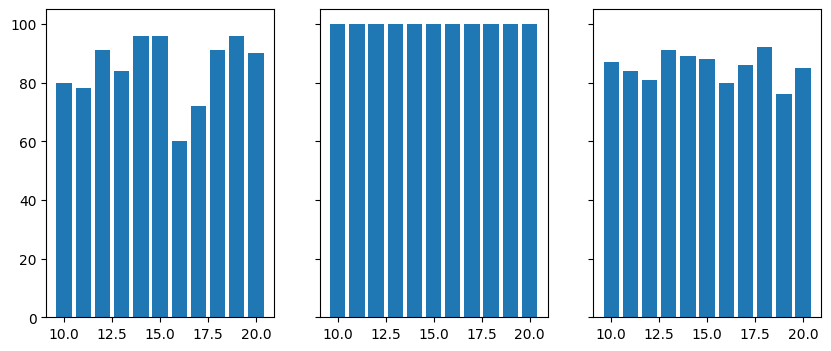

In [19]:
results_data = test_models(models=models)

df = pd.DataFrame(list(zip(range(min_size,max_size+1), results_data)), columns=['size','results'])
df['draws_softmax'] = [r[0][0] for r in df['results']]
df['draws_argmax'] = [r[1][0] for r in df['results']]
df['wins_rand'] = [r[2][1] for r in df['results']]

fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(10, 4))

ax[0].bar(df['size'], df['draws_softmax'])
ax[1].bar(df['size'], df['draws_argmax'])
ax[2].bar(df['size'], df['wins_rand'])
plt.show()

The losses due to illegal moves is where we hope to see further significant improvement.

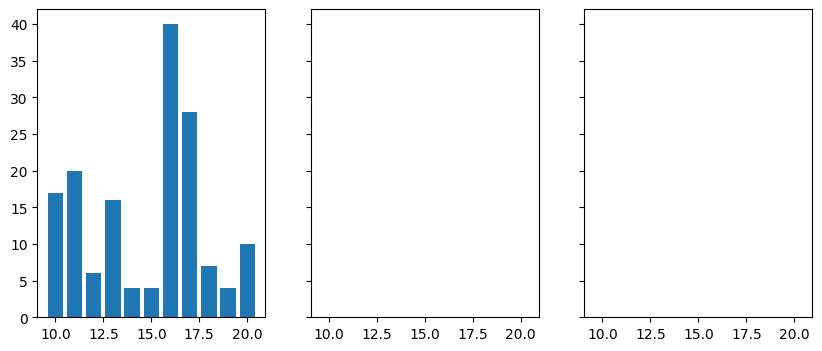

In [20]:
df['illegals_softmax'] = [r[0][3] for r in df['results']]
df['illegals_argmax'] = [r[1][3] for r in df['results']]
df['illegals_rand'] = [r[2][3] for r in df['results']]

fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(10, 4))

ax[0].bar(df['size'], df['illegals_softmax'])
ax[1].bar(df['size'], df['illegals_argmax'])
ax[2].bar(df['size'], df['illegals_rand'])
plt.show()

## Example 6.5

The final experiment in this chapter will be with models where the residual weights are free to train. In addition to the relationship between the size of the hidden layers and performance, we will examine the weights of the residual connections for particular models to see if the model has followed the intuition.

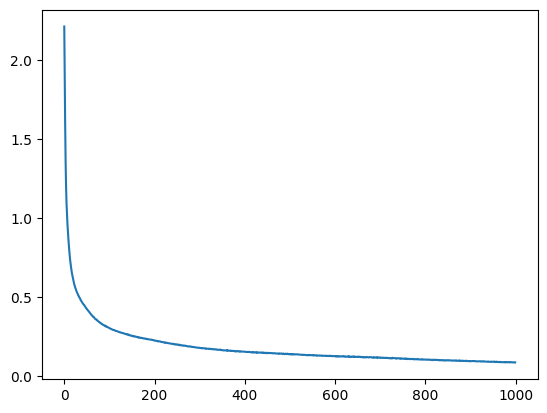

In [21]:
r = 0.002
epochs = 1000
batch_size = 64

M = make_res_model(p=15, q=15, r=r, residual_train=True)
hist = train_model_suggestions(M=M, epochs=epochs, batch_size=batch_size)
plt.plot(hist.history['loss'])
plt.show()

In [22]:
test_one_model(M=M, no_games=100)

Without argmax, versus perfect player:
Draws: 92, 
Wins: 0, 
Losses: 8, 
Losses due to illegal moves: 1

With argmax, versus perfect player:
Draws: 100, 
Wins: 0, 
Losses: 0, 
Losses due to illegal moves: 0

With argmax, versus random player:
Draws: 17, 
Wins: 83, 
Losses: 0, 
Losses due to illegal moves: 0


At this point we can see that reducing the size of the hidden layers still comfortably produces a model that is able to draw against the perfect player every time using argmax and even the vast majority of the time with the softmax probabilities. We can therefore shift the range of network sizes tested here to see if we can still produce good models with even smaller hidden layers.

In [23]:
min_size = 5
max_size = 15

models = []
hists = []
for size in range(min_size, max_size+1):
    M = make_res_model(p=size, q=size, r=0.002, residual_train=True)
    hist = train_model_suggestions(M=M, epochs=1000, batch_size=64)
    models.append(M)
    hists.append(hist)

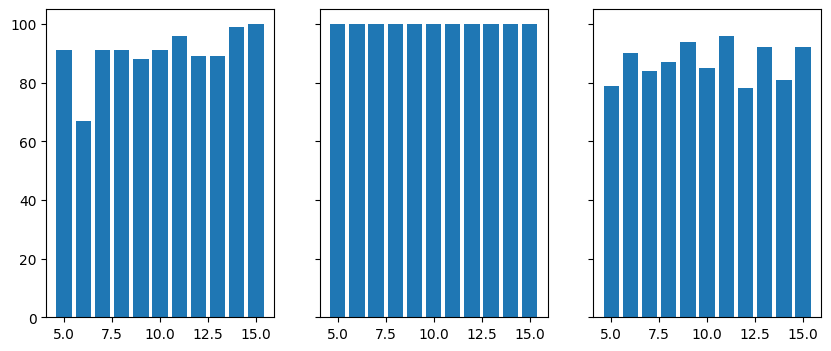

In [24]:
results_data = test_models(models=models)

df = pd.DataFrame(list(zip(range(min_size,max_size+1), results_data)), columns=['size','results'])
df['draws_softmax'] = [r[0][0] for r in df['results']]
df['draws_argmax'] = [r[1][0] for r in df['results']]
df['wins_rand'] = [r[2][1] for r in df['results']]

fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(10, 4))

ax[0].bar(df['size'], df['draws_softmax'])
ax[1].bar(df['size'], df['draws_argmax'])
ax[2].bar(df['size'], df['wins_rand'])
plt.show()

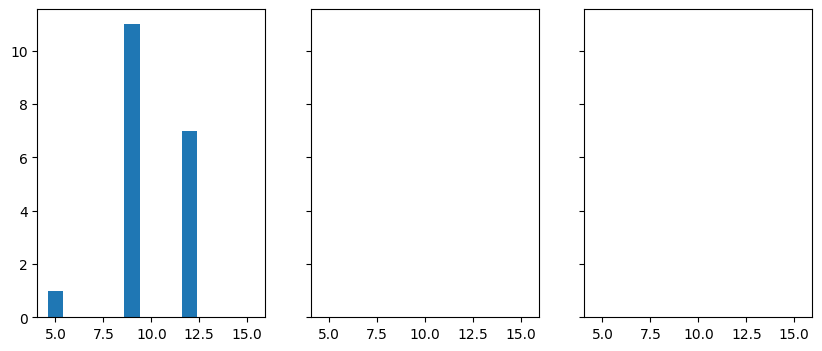

In [25]:
df['illegals_softmax'] = [r[0][3] for r in df['results']]
df['illegals_argmax'] = [r[1][3] for r in df['results']]
df['illegals_rand'] = [r[2][3] for r in df['results']]

fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(10, 4))

ax[0].bar(df['size'], df['illegals_softmax'])
ax[1].bar(df['size'], df['illegals_argmax'])
ax[2].bar(df['size'], df['illegals_rand'])
plt.show()

We find that reducing the size of the hidden layers to as little as 5 still creates good models even using the softmax probabilities, and near-perfect models using argmax. Inspecting the weights of the residual connections of the smallest model, it is clear that the model is indeed applying penalties to occupied positions as suspected. The layout of the weights follows the reshaping to the input, so the rows alternate between the inputs from each player as the position goes from position 0 to position 8.

In [26]:
print(np.round(models[0].layers[5].get_weights()[0],1))

[[-27.3   1.4   4.    0.7  -1.9   1.    1.8   0.3  -3. ]
 [-15.1   0.3   0.5   0.5   2.8  -1.6  -1.2  -1.1   2.1]
 [  0.8 -24.7   0.1   0.6  -0.   -0.3   0.3   0.7   0.1]
 [ -0.7 -20.4   6.8  -1.7  -1.1   0.4  -1.5   1.6  -1.2]
 [ -1.2   0.7 -24.3   2.1   0.3   2.4   2.3  -0.5  -1. ]
 [ -0.6   6.5 -17.4  -3.9   1.9   1.4  -0.4  -0.6  -0.1]
 [  0.4  -0.5   0.3 -24.3   1.    0.4   0.8  -0.    0.9]
 [ -0.7   1.8  -1.5 -15.8  -1.7   5.9   1.9  -0.5  -2.7]
 [ -2.2   1.1  -1.1   4.2 -26.5   5.4  -0.7   2.5  -0.4]
 [  0.1  -1.3   4.3  -1.1 -17.9   0.7   4.4  -2.4  -1.9]
 [ -0.5   0.    0.7   0.6   0.5 -22.6   1.    0.1  -0. ]
 [ -0.4  -0.3   1.5   4.6  -1.9 -17.4  -2.4  -0.3   0.6]
 [  0.2   0.5   0.    0.4  -0.6  -0.7 -21.5   1.4   1.7]
 [ -3.    0.9   4.3   4.3   1.6  -1.  -14.4   0.9  -4.2]
 [ -0.4   2.5  -0.1   0.7  -0.   -0.4   0.7 -18.9   0.4]
 [ -0.7  -0.8   0.9  -0.8  -1.4   1.5   1.9 -18.8   1.1]
 [ -1.2   0.7   1.    0.3  -0.8   1.4   0.7   0.9 -19.3]
 [ -0.6   1.4  -0.4   0.5   1.7

## Figure code

The following code produce the figures contained in this chapter.

Text(0.5, 0.98, 'Loss over time for models with two dense layers: p=20, q=20')

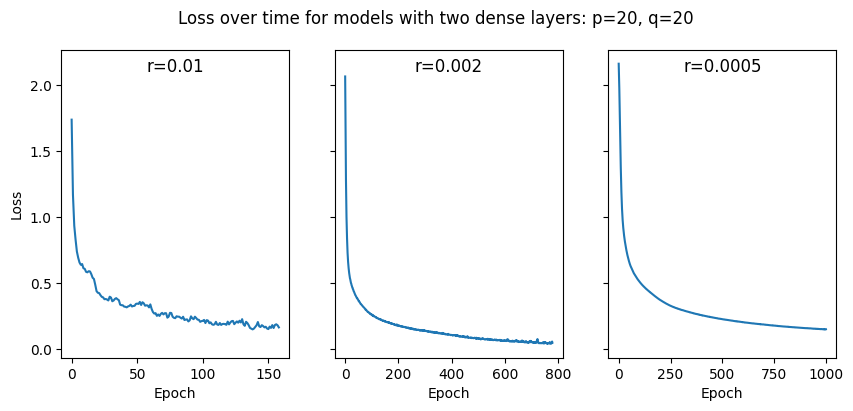

In [46]:
tf.random.set_seed(210138711)

# Figure 1
fig, axs = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(10, 4))

M = make_simple_model(p=20, q=20, r=0.01)
hist = train_model_suggestions(M=M, epochs=1000, batch_size=64)
axs[0].plot(hist.history['loss'])
axs[0].set_title('r=0.01', y=0.9)

M = make_simple_model(p=20, q=20, r=0.002)
hist = train_model_suggestions(M=M, epochs=1000, batch_size=64)
axs[1].plot(hist.history['loss'])
axs[1].set_title('r=0.002', y=0.9)

M = make_simple_model(p=20, q=20, r=0.0005)
hist = train_model_suggestions(M=M, epochs=1000, batch_size=64)
axs[2].plot(hist.history['loss'])
axs[2].set_title('r=0.0005', y=0.9)

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle('Loss over time for models with two dense layers: p=20, q=20')


In [47]:
tf.random.set_seed(210138711)

# Table 1
models = []
for size in range(10, 21):
    M = make_simple_model(p=size, q=size, r=0.002)
    train_model_suggestions(M=M, epochs=1000, batch_size=64)
    models.append(M)

results_data = test_models(models=models)


    size                                            results  draws_softmax  \
0     10  [[40, 0, 60, 51, 0], [100, 0, 0, 0, 0], [26, 6...             40   
1     11  [[29, 0, 71, 47, 0], [0, 0, 100, 100, 0], [14,...             29   
2     12  [[50, 0, 50, 19, 0], [0, 0, 100, 0, 0], [18, 7...             50   
3     13  [[76, 0, 24, 14, 0], [100, 0, 0, 0, 0], [21, 7...             76   
4     14  [[34, 0, 66, 63, 0], [0, 0, 100, 100, 0], [21,...             34   
5     15  [[50, 0, 50, 46, 0], [0, 0, 100, 100, 0], [6, ...             50   
6     16  [[77, 0, 23, 20, 0], [100, 0, 0, 0, 0], [33, 6...             77   
7     17  [[48, 0, 52, 6, 0], [0, 0, 100, 0, 0], [22, 73...             48   
8     18  [[61, 0, 39, 38, 0], [100, 0, 0, 0, 0], [6, 94...             61   
9     19  [[68, 0, 32, 32, 0], [100, 0, 0, 0, 0], [17, 8...             68   
10    20  [[96, 0, 4, 4, 0], [100, 0, 0, 0, 0], [8, 92, ...             96   

    wins_softmax  losses_softmax  draws_argmax  wins_argmax  lo

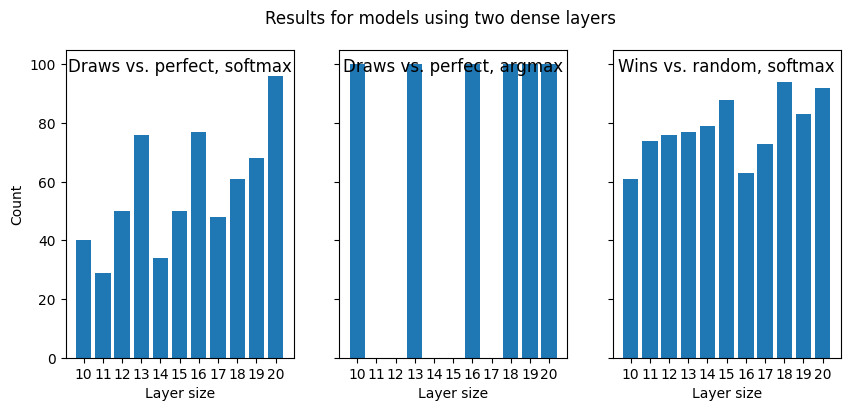

In [48]:
# Figure 2
df = pd.DataFrame(list(zip(range(10,21), results_data)), columns=['size','results'])
df['draws_softmax'] = [r[0][0] for r in df['results']]
df['wins_softmax'] = [r[0][1] for r in df['results']]
df['losses_softmax'] = [r[0][2] for r in df['results']]
df['draws_argmax'] = [r[1][0] for r in df['results']]
df['wins_argmax'] = [r[1][1] for r in df['results']]
df['losses_argmax'] = [r[1][2] for r in df['results']]
df['draws_rand'] = [r[2][0] for r in df['results']]
df['wins_rand'] = [r[2][1] for r in df['results']]
df['losses_rand'] = [r[2][2] for r in df['results']]
df['illegals_softmax'] = [r[0][3] for r in df['results']]
df['illegals_argmax'] = [r[1][3] for r in df['results']]
df['illegals_rand'] = [r[2][3] for r in df['results']]
print(df)

fig, axs = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(10, 4))

axs[0].bar(df['size'], df['draws_softmax'])
axs[0].set_title('Draws vs. perfect, softmax', y=0.9)
axs[1].bar(df['size'], df['draws_argmax'])
axs[1].set_title('Draws vs. perfect, argmax', y=0.9)
axs[2].bar(df['size'], df['wins_rand'])
axs[2].set_title('Wins vs. random, argmax', y=0.9)

for ax in axs.flat:
    ax.set(xlabel='Layer size', ylabel='Count')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.set_xticks(df['size'])
    ax.label_outer()

fig.suptitle('Results for models using two dense layers')

plt.show()

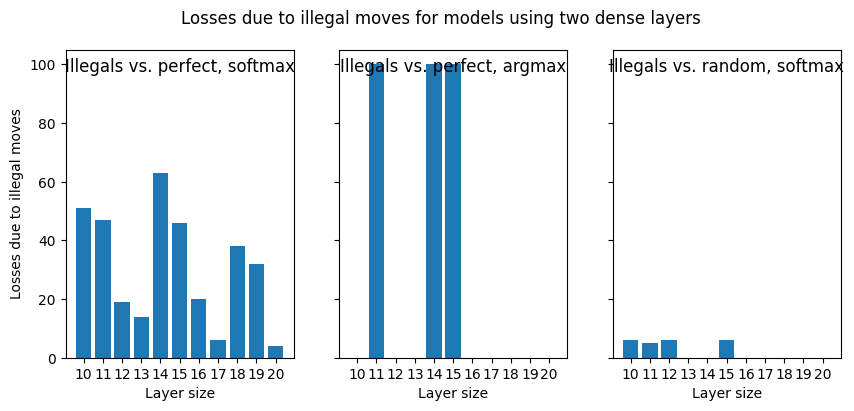

In [49]:
# Figure 3
fig, axs = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(10, 4))

axs[0].bar(df['size'], df['illegals_softmax'])
axs[0].set_title('Illegals vs. perfect, softmax', y=0.9)
axs[1].bar(df['size'], df['illegals_argmax'])
axs[1].set_title('Illegals vs. perfect, argmax', y=0.9)
axs[2].bar(df['size'], df['illegals_rand'])
axs[2].set_title('Illegals vs. random, argmax', y=0.9)

for ax in axs.flat:
    ax.set(xlabel='Layer size', ylabel='Losses due to illegal moves')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.set_xticks(df['size'])
    ax.label_outer()

fig.suptitle('Losses due to illegal moves for models using two dense layers')

plt.show()

In [50]:
tf.random.set_seed(210138711)

# Table 2
models = []
hists = []
for size in range(10, 21):
    M = make_res_model(p=size, q=size, r=0.002, residual_train=False, fix_pen=20)
    hist = train_model_suggestions(M=M, epochs=1000, batch_size=64)
    models.append(M)
    hists.append(hist)

results_data = test_models(models=models)

    size                                            results  draws_softmax  \
0     10  [[96, 0, 4, 4, 0], [100, 0, 0, 0, 0], [17, 83,...             96   
1     11  [[86, 0, 14, 14, 0], [100, 0, 0, 0, 0], [15, 8...             86   
2     12  [[88, 0, 12, 12, 0], [100, 0, 0, 0, 0], [8, 92...             88   
3     13  [[84, 0, 16, 16, 0], [100, 0, 0, 0, 0], [7, 92...             84   
4     14  [[82, 0, 18, 18, 0], [100, 0, 0, 0, 0], [9, 91...             82   
5     15  [[74, 0, 26, 20, 0], [100, 0, 0, 0, 0], [12, 8...             74   
6     16  [[99, 0, 1, 1, 0], [100, 0, 0, 0, 0], [10, 90,...             99   
7     17  [[94, 0, 6, 6, 0], [100, 0, 0, 0, 0], [17, 83,...             94   
8     18  [[100, 0, 0, 0, 0], [100, 0, 0, 0, 0], [16, 84...            100   
9     19  [[94, 0, 6, 6, 0], [100, 0, 0, 0, 0], [15, 84,...             94   
10    20  [[85, 0, 15, 15, 0], [100, 0, 0, 0, 0], [11, 8...             85   

    wins_softmax  losses_softmax  draws_argmax  wins_argmax  lo

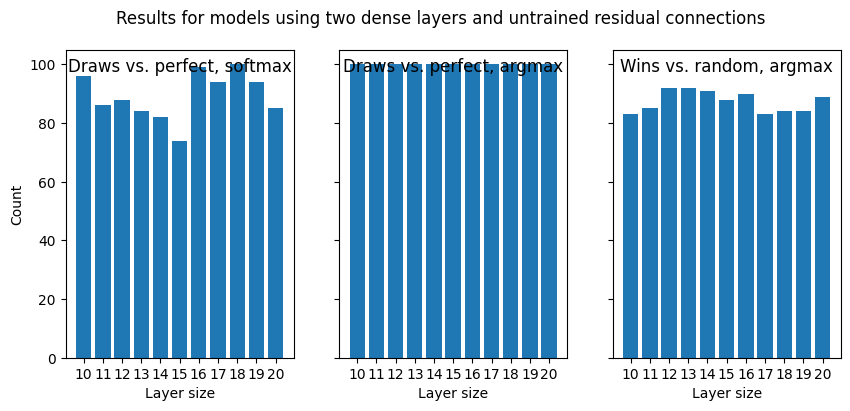

In [51]:
# Figure 4
df = pd.DataFrame(list(zip(range(10,21), results_data)), columns=['size','results'])
df['draws_softmax'] = [r[0][0] for r in df['results']]
df['wins_softmax'] = [r[0][1] for r in df['results']]
df['losses_softmax'] = [r[0][2] for r in df['results']]
df['draws_argmax'] = [r[1][0] for r in df['results']]
df['wins_argmax'] = [r[1][1] for r in df['results']]
df['losses_argmax'] = [r[1][2] for r in df['results']]
df['draws_rand'] = [r[2][0] for r in df['results']]
df['wins_rand'] = [r[2][1] for r in df['results']]
df['losses_rand'] = [r[2][2] for r in df['results']]
df['illegals_softmax'] = [r[0][3] for r in df['results']]
df['illegals_argmax'] = [r[1][3] for r in df['results']]
df['illegals_rand'] = [r[2][3] for r in df['results']]
print(df)

fig, axs = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(10, 4))

axs[0].bar(df['size'], df['draws_softmax'])
axs[0].set_title('Draws vs. perfect, softmax', y=0.9)
axs[1].bar(df['size'], df['draws_argmax'])
axs[1].set_title('Draws vs. perfect, argmax', y=0.9)
axs[2].bar(df['size'], df['wins_rand'])
axs[2].set_title('Wins vs. random, argmax', y=0.9)

for ax in axs.flat:
    ax.set(xlabel='Layer size', ylabel='Count')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.set_xticks(df['size'])
    ax.label_outer()

fig.suptitle('Results for models using two dense layers and untrained residual connections')

plt.show()

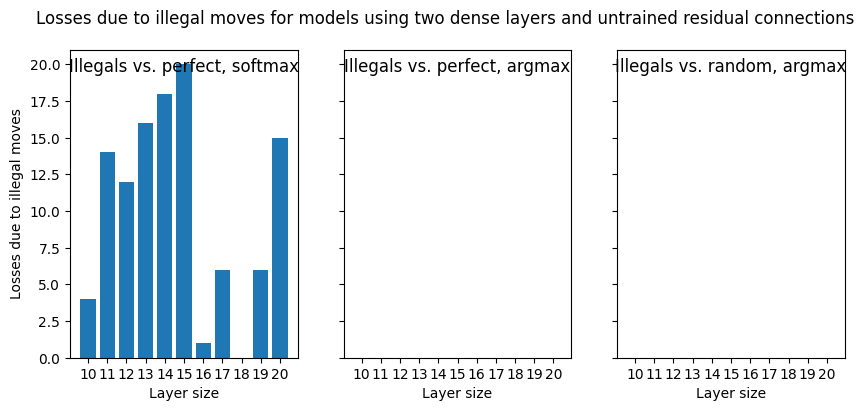

In [52]:
# Figure 5
fig, axs = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(10, 4))

axs[0].bar(df['size'], df['illegals_softmax'])
axs[0].set_title('Illegals vs. perfect, softmax', y=0.9)
axs[1].bar(df['size'], df['illegals_argmax'])
axs[1].set_title('Illegals vs. perfect, argmax', y=0.9)
axs[2].bar(df['size'], df['illegals_rand'])
axs[2].set_title('Illegals vs. random, argmax', y=0.9)

for ax in axs.flat:
    ax.set(xlabel='Layer size', ylabel='Losses due to illegal moves')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.set_xticks(df['size'])
    ax.label_outer()

fig.suptitle('Losses due to illegal moves for models using two dense layers and untrained residual connections')

plt.show()

In [53]:
tf.random.set_seed(210138711)

# Table 3
models = []
hists = []
for size in range(5, 16):
    M = make_res_model(p=size, q=size, r=0.002, residual_train=True)
    hist = train_model_suggestions(M=M, epochs=1000, batch_size=64)
    models.append(M)
    hists.append(hist)

results_data = test_models(models=models)

    size                                            results  draws_softmax  \
0     10  [[86, 0, 14, 0, 0], [100, 0, 0, 0, 0], [13, 87...             86   
1     11  [[84, 0, 16, 0, 0], [100, 0, 0, 0, 0], [14, 85...             84   
2     12  [[95, 0, 5, 0, 0], [100, 0, 0, 0, 0], [19, 81,...             95   
3     13  [[99, 0, 1, 0, 0], [100, 0, 0, 0, 0], [22, 78,...             99   
4     14  [[95, 0, 5, 0, 0], [100, 0, 0, 0, 0], [25, 72,...             95   
5     15  [[91, 0, 9, 0, 0], [100, 0, 0, 0, 0], [23, 76,...             91   
6     16  [[99, 0, 1, 0, 0], [100, 0, 0, 0, 0], [15, 85,...             99   
7     17  [[93, 0, 7, 1, 0], [100, 0, 0, 0, 0], [15, 85,...             93   
8     18  [[97, 0, 3, 0, 0], [100, 0, 0, 0, 0], [17, 82,...             97   
9     19  [[98, 0, 2, 2, 0], [100, 0, 0, 0, 0], [15, 85,...             98   
10    20  [[94, 0, 6, 5, 0], [100, 0, 0, 0, 0], [14, 82,...             94   

    wins_softmax  losses_softmax  draws_argmax  wins_argmax  lo

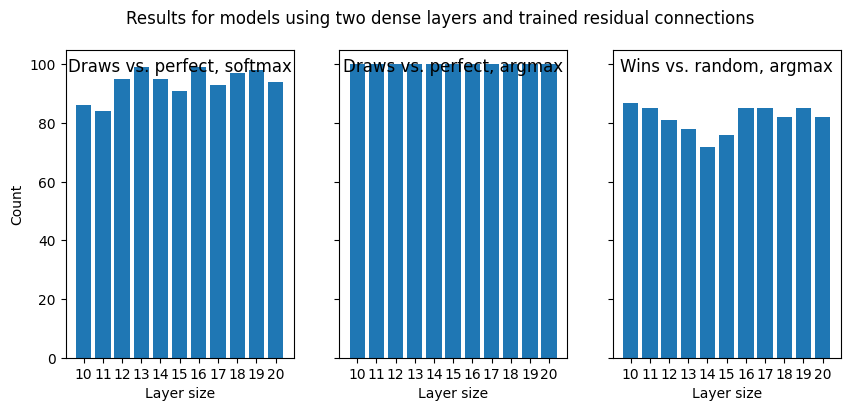

In [54]:
# Figure 6
df = pd.DataFrame(list(zip(range(5,16), results_data)), columns=['size','results'])
df['draws_softmax'] = [r[0][0] for r in df['results']]
df['wins_softmax'] = [r[0][1] for r in df['results']]
df['losses_softmax'] = [r[0][2] for r in df['results']]
df['draws_argmax'] = [r[1][0] for r in df['results']]
df['wins_argmax'] = [r[1][1] for r in df['results']]
df['losses_argmax'] = [r[1][2] for r in df['results']]
df['draws_rand'] = [r[2][0] for r in df['results']]
df['wins_rand'] = [r[2][1] for r in df['results']]
df['losses_rand'] = [r[2][2] for r in df['results']]
df['illegals_softmax'] = [r[0][3] for r in df['results']]
df['illegals_argmax'] = [r[1][3] for r in df['results']]
df['illegals_rand'] = [r[2][3] for r in df['results']]
print(df)

fig, axs = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(10, 4))

axs[0].bar(df['size'], df['draws_softmax'])
axs[0].set_title('Draws vs. perfect, softmax', y=0.9)
axs[1].bar(df['size'], df['draws_argmax'])
axs[1].set_title('Draws vs. perfect, argmax', y=0.9)
axs[2].bar(df['size'], df['wins_rand'])
axs[2].set_title('Wins vs. random, argmax', y=0.9)

for ax in axs.flat:
    ax.set(xlabel='Layer size', ylabel='Count')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.set_xticks(df['size'])
    ax.label_outer()

fig.suptitle('Results for models using two dense layers and trained residual connections')

plt.show()

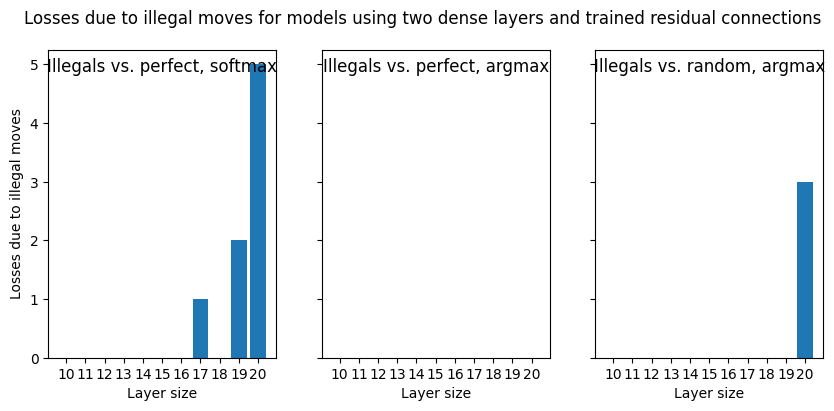

In [55]:
# Figure 7
fig, axs = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(10, 4))

axs[0].bar(df['size'], df['illegals_softmax'])
axs[0].set_title('Illegals vs. perfect, softmax', y=0.9)
axs[1].bar(df['size'], df['illegals_argmax'])
axs[1].set_title('Illegals vs. perfect, argmax', y=0.9)
axs[2].bar(df['size'], df['illegals_rand'])
axs[2].set_title('Illegals vs. random, argmax', y=0.9)

for ax in axs.flat:
    ax.set(xlabel='Layer size', ylabel='Losses due to illegal moves')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.set_xticks(df['size'])
    ax.label_outer()

fig.suptitle('Losses due to illegal moves for models using two dense layers and trained residual connections')

plt.show()